# 6. TRPO

本书之前介绍的基于策略的方法包括策略梯度算法和 Actor-Critic 算法。这些方法虽然简单、直观，但在实际应用过程中会遇到训练不稳定的情况。当策略网络是深度模型时，沿着策略梯度更新参数，很有可能由于步长太长，策略突然显著变差，进而影响训练效果。

针对以上问题，我们考虑在更新时找到一块信任区域（trust region），在这个区域上更新策略时能够得到某种策略性能的安全性保证，这就是信任区域策略优化（trust region policy optimization，TRPO）算法的主要思想。TRPO 算法在 2015 年被提出，它在理论上能够保证策略学习的性能单调性，并在实际应用中取得了比策略梯度算法更好的效果。

TRPO的核心目标就是在保证策略性能单调提升的前提下，尽可能地最大化策略的更新幅度。找到一个“信任域”，在这个“信赖域”内，找到能让预期回报最大化的那一步，然后移动到那个位置。接着，在新的位置重新划定一个新的信赖域，重复这个过程。 

## 6.1 Theory
TRPO的实现主要涉及以下几个关键点：

(1) **优化目标**：优势函数 A(s, a)，在状态s下，执行动作a比通常情况（平均水平）好多少。

(2) **关键约束**：KL散度

TRPO如何定义那个“信赖域”的圈呢？它使用的是KL散度（Kullback-Leibler Divergence）。
KL散度它不是一个距离度量，但可以衡量两个概率分布之间的差异。在这里，它被用来衡量新策略和旧策略之间的“距离”。

TRPO的约束：它要求新、旧策略的KL散度不能超过一个很小的阈值（比如0.01）。这就好比给策略更新的步伐画了一个半径，确保新策略不会和旧策略偏离太远。 

所以，TRPO的优化问题可以通俗地描述为：在满足“新旧策略变化不大”的约束下，尽可能地让新策略获得更大的回报。

(3) **求解方法**：共轭梯度法

由于这个带约束的优化问题很难直接用常规的梯度下降法求解，TRPO采用了一种叫做共轭梯度法（Conjugate Gradient Method） 的技术来近似求解更新方向。这是一个计算比较复杂的部分，也是TRPO实现起来比较困难的原因之一。

## 6.2 Framework

In [1]:
import gymnasium as gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import rl_utils
import copy

In [2]:
def compute_advantage(gamma, lmbda, td_delta):
    '''泛化优势估计 (GAE)'''
    # 将PyTorch Tensor转换为Numpy Array，并脱离计算图
    td_delta = td_delta.detach().numpy()
    advantage_list = [] # 优势函数列表
    advantage = 0.0
    for delta in td_delta[::-1]:    # 从后向前遍历
        advantage = gamma * lmbda * advantage + delta   # GAE递归计算公式
        advantage_list.append(advantage)
    advantage_list.reverse()
    return torch.tensor(advantage_list, dtype=torch.float)

In [3]:
class PolicyNet(torch.nn.Module):
    '''定义策略网络, 和ac一样'''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)  # 输出的维度是action_dim

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)    # 输出动作概率


class ValueNet(torch.nn.Module):
    '''定义价值网络, 和ac一样'''
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)   # 输出维度是1

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)  # 输出状态价值


class TRPO:
    """ TRPO算法 """
    def __init__(self, hidden_dim, state_space, action_space, lmbda,
                 kl_constraint, alpha, critic_lr, gamma, device):
        state_dim = state_space.shape[0]
        action_dim = action_space.n

        # 策略网络参数不需要优化器更新 因为是有约束的优化问题 不能直接用optimizer 需要自定义
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda  # GAE参数
        self.kl_constraint = kl_constraint  # KL距离最大限制
        self.alpha = alpha  # 线性搜索参数
        self.device = device

    def take_action(self, state):   # 使用策略网络来选择动作
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def hessian_matrix_vector_product(self, states, old_action_dists, vector):
        '''计算海森矩阵和一个向量的乘积'''
        # 计算函数 f(θ)，也就是KL散度。需要先根据当前参数计算出新的动作分布
        new_action_dists = torch.distributions.Categorical(self.actor(states))
        # KL散度 f(θ)
        kl = torch.mean(
            torch.distributions.kl.kl_divergence(old_action_dists,
                                                 new_action_dists))
        # KL散度求导 g = ∇_θ f(θ) = ∇_θ(kl)
        # create_graph=True: 为梯度本身构建一个计算图，这样才能对梯度再次求导
        kl_grad = torch.autograd.grad(kl,
                                      self.actor.parameters(),
                                      create_graph=True)    
        # 将梯度 g 展平成一个单一的长向量
        kl_grad_vector = torch.cat([grad.view(-1) for grad in kl_grad])

        # KL距离的梯度先和向量进行点积运算
        kl_grad_vector_product = torch.dot(kl_grad_vector, vector)
        # 点积的结果求导 
        # create_graph 默认为 False, 因为不用再次求导了
        grad2 = torch.autograd.grad(kl_grad_vector_product,
                                    self.actor.parameters())
        # 将最终结果展平成一个向量并返回
        grad2_vector = torch.cat([grad.view(-1) for grad in grad2])
        return grad2_vector


    def conjugate_gradient(self, grad, states, old_action_dists):  
        '''共轭梯度法求解方程'''
        x = torch.zeros_like(grad)  # 最终要求解的策略更新方向
        r = grad.clone()    # 残差 r = g - Hx，初始化r=g
        p = grad.clone()    # 搜索方向, 沿哪个方向探索 初始化为梯度方向
        rdotr = torch.dot(r, r) # 点积
        for i in range(10):  # 共轭梯度主循环
            # 计算 H*p
            Hp = self.hessian_matrix_vector_product(states, old_action_dists, p)

            # 最佳步长 alpha = (r^T * r) / (p^T * H * p) 是共轭梯度法的标准公式
            alpha = rdotr / torch.dot(p, Hp)

            # 更新解和残差
            x += alpha * p
            r -= alpha * Hp
            new_rdotr = torch.dot(r, r)

            # 是否收敛
            if new_rdotr < 1e-10:
                break
            beta = new_rdotr / rdotr
            p = r + beta * p    # 下一次搜索方向
            rdotr = new_rdotr
        return x

    def compute_surrogate_obj(self, states, actions, advantage, old_log_probs,
                              actor):
        '''替代目标函数'''
        # 新策略下，采取同样动作的对数概率
        log_probs = torch.log(actor(states).gather(1, actions))
        # 新旧策略的概率比率
        ratio = torch.exp(log_probs - old_log_probs)
        # 计算替代目标函数，并返回其均值
        return torch.mean(ratio * advantage)


    def line_search(self, states, actions, advantage, old_log_probs,
                    old_action_dists, max_vec):
        '''
        线性搜索：
        从理论最大步长开始, 不断尝试缩短步长, 
        直到找到一个既能真正提升策略性能, 又严格满足KL散度约束的“安全步长”, 然后执行更新
        '''
        old_para = torch.nn.utils.convert_parameters.parameters_to_vector(
            self.actor.parameters())
        # 当前策略的目标函数值
        old_obj = self.compute_surrogate_obj(states, actions, advantage,
                                             old_log_probs, self.actor)
        for i in range(15):  # 线性搜索主循环
            coef = self.alpha**i
            new_para = old_para + coef * max_vec   # max_vec: 最大更新向量  
            # 创建一个临时的Actor网络 不能直接修改 self.actor     
            new_actor = copy.deepcopy(self.actor)
            torch.nn.utils.convert_parameters.vector_to_parameters(
                new_para, new_actor.parameters())
            # 计算它在新参数下的动作分布
            new_action_dists = torch.distributions.Categorical(
                new_actor(states))
            # KL散度 新旧策略之间的差异
            kl_div = torch.mean(
                torch.distributions.kl.kl_divergence(old_action_dists,
                                                     new_action_dists))
            # 新目标函数值
            new_obj = self.compute_surrogate_obj(states, actions, advantage,
                                                 old_log_probs, new_actor)
            # 如果新目标函数值更大且KL散度满足约束 则更新参数
            if new_obj > old_obj and kl_div < self.kl_constraint:
                return new_para
        # 如果15次仍没寻找到合适的步长 则返回旧的参数
        return old_para


    def policy_learn(self, states, actions, old_action_dists, old_log_probs,
                     advantage):  # 更新策略函数
        # 计算替代目标函数 L(θ)，这是我们想要最大化的目标
        surrogate_obj = self.compute_surrogate_obj(states, actions, advantage,
                                                   old_log_probs, self.actor)
        
        # 计算目标函数 L(θ) 关于当前 actor 参数的梯度 g
        grads = torch.autograd.grad(surrogate_obj, self.actor.parameters())

        # 将梯度 g 展平成一个一维向量，并用 .detach() 将其从计算图中分离
        obj_grad = torch.cat([grad.view(-1) for grad in grads]).detach()

        # 用共轭梯度法计算x = H^(-1)g
        descent_direction = self.conjugate_gradient(obj_grad, states,
                                                    old_action_dists)

        # 计算 H*s。这是为了计算步长，需要再调用一次 HVP 函数
        Hd = self.hessian_matrix_vector_product(states, old_action_dists,
                                                descent_direction)
        
        # 计算理论上的最大步长系数
        max_coef = torch.sqrt(2 * self.kl_constraint /
                              (torch.dot(descent_direction, Hd) + 1e-8))
        
        # 线性搜索 找到理想的最大更新步长
        new_para = self.line_search(states, actions, advantage, old_log_probs,
                                    old_action_dists,
                                    descent_direction * max_coef)
        # 用线性搜索后的参数更新策略
        torch.nn.utils.convert_parameters.vector_to_parameters(
            new_para, self.actor.parameters())

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_delta = td_target - self.critic(states)
        advantage = compute_advantage(self.gamma, self.lmbda,
                                      td_delta.cpu()).to(self.device)
        old_log_probs = torch.log(self.actor(states).gather(1,
                                                            actions)).detach()
        old_action_dists = torch.distributions.Categorical(
            self.actor(states).detach())
        critic_loss = torch.mean(
            F.mse_loss(self.critic(states), td_target.detach()))
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()  # 更新价值函数
        # 更新策略函数
        self.policy_learn(states, actions, old_action_dists, old_log_probs,
                          advantage)

## 6.3 Discrete Env
在车杆环境中训练 TRPO，并将结果可视化。

In [5]:
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
critic_lr = 1e-2
kl_constraint = 0.0005
alpha = 0.5
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v1'
env = gym.make(env_name)
env.reset(seed=0)
torch.manual_seed(0)
agent = TRPO(hidden_dim, env.observation_space, env.action_space, lmbda,
             kl_constraint, alpha, critic_lr, gamma, device)
return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

Iteration 9: 100%|██████████| 100/100 [00:01<00:00, 61.53it/s, episode=1000, return=182.100]


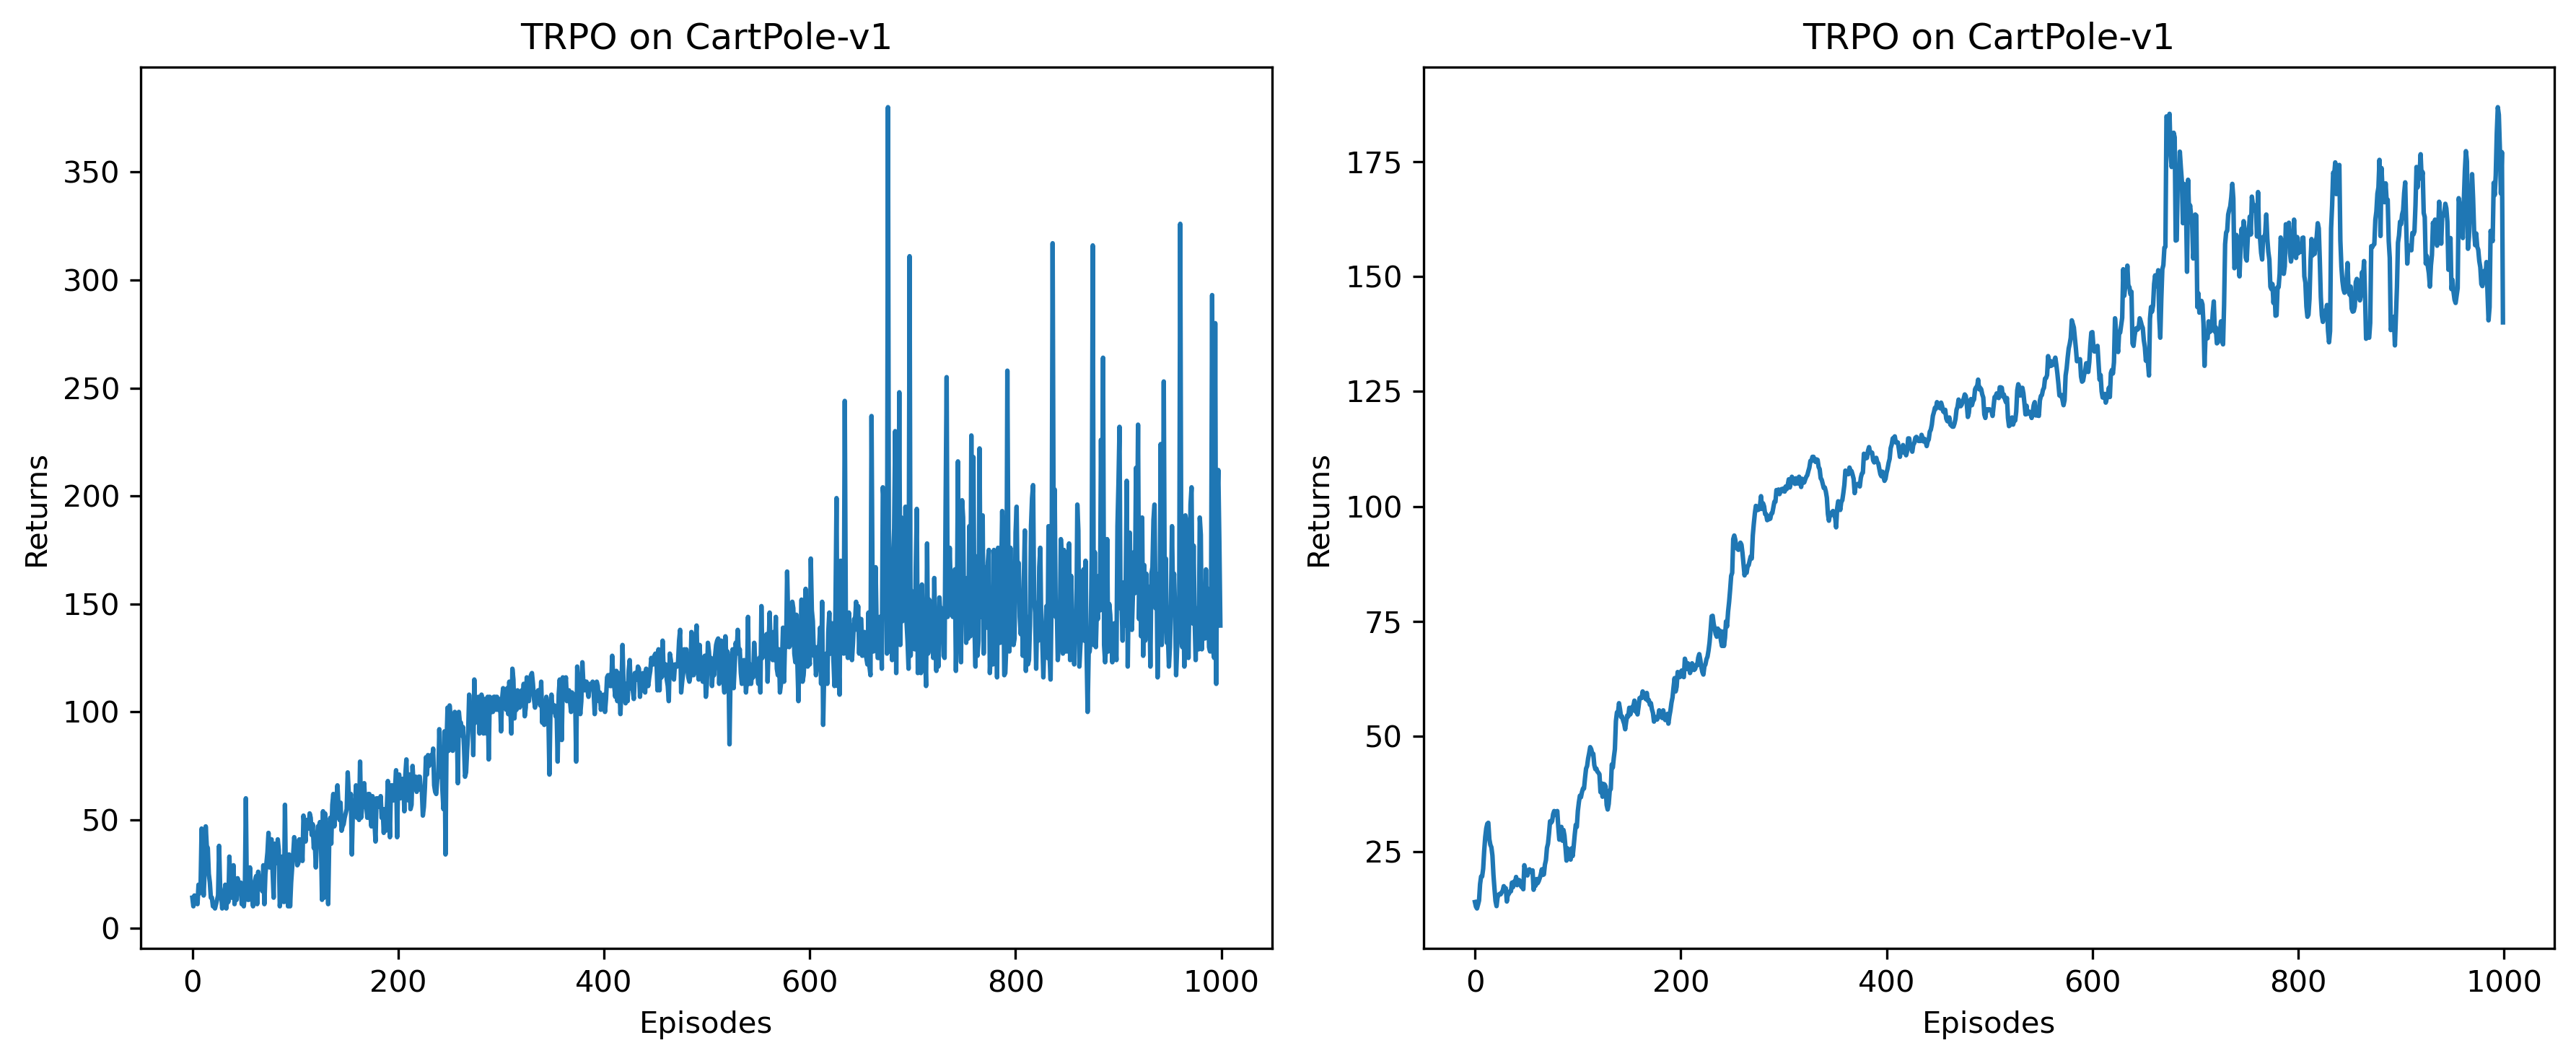

In [6]:
episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 9)

plt.figure(figsize=(12, 5), dpi = 300)
plt.subplot(1, 2, 1)
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))

plt.subplot(1, 2, 2)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.tight_layout()
plt.show()

## 6.4 Continuous Env
接下来尝试倒立摆环境。对于策略网络，因为环境是连续动作的，所以策略网络分别输出表示动作分布的高斯分布的均值和标准差。

In [7]:
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)    # 均值
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)   # 标准差

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = 2.0 * torch.tanh(self.fc_mu(x))    # 计算均值 mu，并进行范围限制
        std = F.softplus(self.fc_std(x))    # 计算标准差 std，并保证其为正数
        return mu, std  # 高斯分布的均值和标准差


class TRPOContinuous:
    """ 处理连续动作的TRPO算法 """
    def __init__(self, hidden_dim, state_space, action_space, lmbda,
                 kl_constraint, alpha, critic_lr, gamma, device):
        state_dim = state_space.shape[0]
        action_dim = action_space.shape[0]
        self.actor = PolicyNetContinuous(state_dim, hidden_dim,
                                         action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.kl_constraint = kl_constraint
        self.alpha = alpha
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        mu, std = self.actor(state)
        action_dist = torch.distributions.Normal(mu, std)   # 正态分布 输入参数均值和标准差
        action = action_dist.sample()   # 在正态分布中采样
        return [action.item()]

    def hessian_matrix_vector_product(self,
                                      states,
                                      old_action_dists,
                                      vector,
                                      damping=0.1):
        mu, std = self.actor(states)
        new_action_dists = torch.distributions.Normal(mu, std)
        kl = torch.mean(
            torch.distributions.kl.kl_divergence(old_action_dists,
                                                 new_action_dists))
        kl_grad = torch.autograd.grad(kl,
                                      self.actor.parameters(),
                                      create_graph=True)
        kl_grad_vector = torch.cat([grad.view(-1) for grad in kl_grad])
        kl_grad_vector_product = torch.dot(kl_grad_vector, vector)
        grad2 = torch.autograd.grad(kl_grad_vector_product,
                                    self.actor.parameters())
        grad2_vector = torch.cat(
            [grad.contiguous().view(-1) for grad in grad2])
        return grad2_vector + damping * vector

    def conjugate_gradient(self, grad, states, old_action_dists):
        x = torch.zeros_like(grad)
        r = grad.clone()
        p = grad.clone()
        rdotr = torch.dot(r, r)
        for i in range(10):
            Hp = self.hessian_matrix_vector_product(states, old_action_dists,
                                                    p)
            alpha = rdotr / torch.dot(p, Hp)
            x += alpha * p
            r -= alpha * Hp
            new_rdotr = torch.dot(r, r)
            if new_rdotr < 1e-10:
                break
            beta = new_rdotr / rdotr
            p = r + beta * p
            rdotr = new_rdotr
        return x

    def compute_surrogate_obj(self, states, actions, advantage, old_log_probs,
                              actor):
        mu, std = actor(states)
        action_dists = torch.distributions.Normal(mu, std)
        log_probs = action_dists.log_prob(actions)
        ratio = torch.exp(log_probs - old_log_probs)
        return torch.mean(ratio * advantage)

    def line_search(self, states, actions, advantage, old_log_probs,
                    old_action_dists, max_vec):
        old_para = torch.nn.utils.convert_parameters.parameters_to_vector(
            self.actor.parameters())
        old_obj = self.compute_surrogate_obj(states, actions, advantage,
                                             old_log_probs, self.actor)
        for i in range(15):
            coef = self.alpha**i
            new_para = old_para + coef * max_vec
            new_actor = copy.deepcopy(self.actor)
            torch.nn.utils.convert_parameters.vector_to_parameters(
                new_para, new_actor.parameters())
            mu, std = new_actor(states)
            new_action_dists = torch.distributions.Normal(mu, std)
            kl_div = torch.mean(
                torch.distributions.kl.kl_divergence(old_action_dists,
                                                     new_action_dists))
            new_obj = self.compute_surrogate_obj(states, actions, advantage,
                                                 old_log_probs, new_actor)
            if new_obj > old_obj and kl_div < self.kl_constraint:
                return new_para
        return old_para

    def policy_learn(self, states, actions, old_action_dists, old_log_probs,
                     advantage):
        surrogate_obj = self.compute_surrogate_obj(states, actions, advantage,
                                                   old_log_probs, self.actor)
        grads = torch.autograd.grad(surrogate_obj, self.actor.parameters())
        obj_grad = torch.cat([grad.view(-1) for grad in grads]).detach()
        descent_direction = self.conjugate_gradient(obj_grad, states,
                                                    old_action_dists)
        Hd = self.hessian_matrix_vector_product(states, old_action_dists,
                                                descent_direction)
        max_coef = torch.sqrt(2 * self.kl_constraint /
                              (torch.dot(descent_direction, Hd) + 1e-8))
        new_para = self.line_search(states, actions, advantage, old_log_probs,
                                    old_action_dists,
                                    descent_direction * max_coef)
        torch.nn.utils.convert_parameters.vector_to_parameters(
            new_para, self.actor.parameters())

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        rewards = (rewards + 8.0) / 8.0  # 对奖励进行修改,方便训练
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)
        advantage = compute_advantage(self.gamma, self.lmbda,
                                      td_delta.cpu()).to(self.device)
        mu, std = self.actor(states)
        old_action_dists = torch.distributions.Normal(mu.detach(),
                                                      std.detach())
        old_log_probs = old_action_dists.log_prob(actions)
        critic_loss = torch.mean(
            F.mse_loss(self.critic(states), td_target.detach()))
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        self.policy_learn(states, actions, old_action_dists, old_log_probs,
                          advantage)

In [8]:
num_episodes = 2000
hidden_dim = 128
gamma = 0.9
lmbda = 0.9
critic_lr = 1e-2
kl_constraint = 0.00005
alpha = 0.5
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)
env.reset(seed=0)
torch.manual_seed(0)
agent = TRPOContinuous(hidden_dim, env.observation_space, env.action_space,
                       lmbda, kl_constraint, alpha, critic_lr, gamma, device)
return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

Iteration 9: 100%|██████████| 200/200 [00:03<00:00, 54.66it/s, episode=2000, return=-469.555]


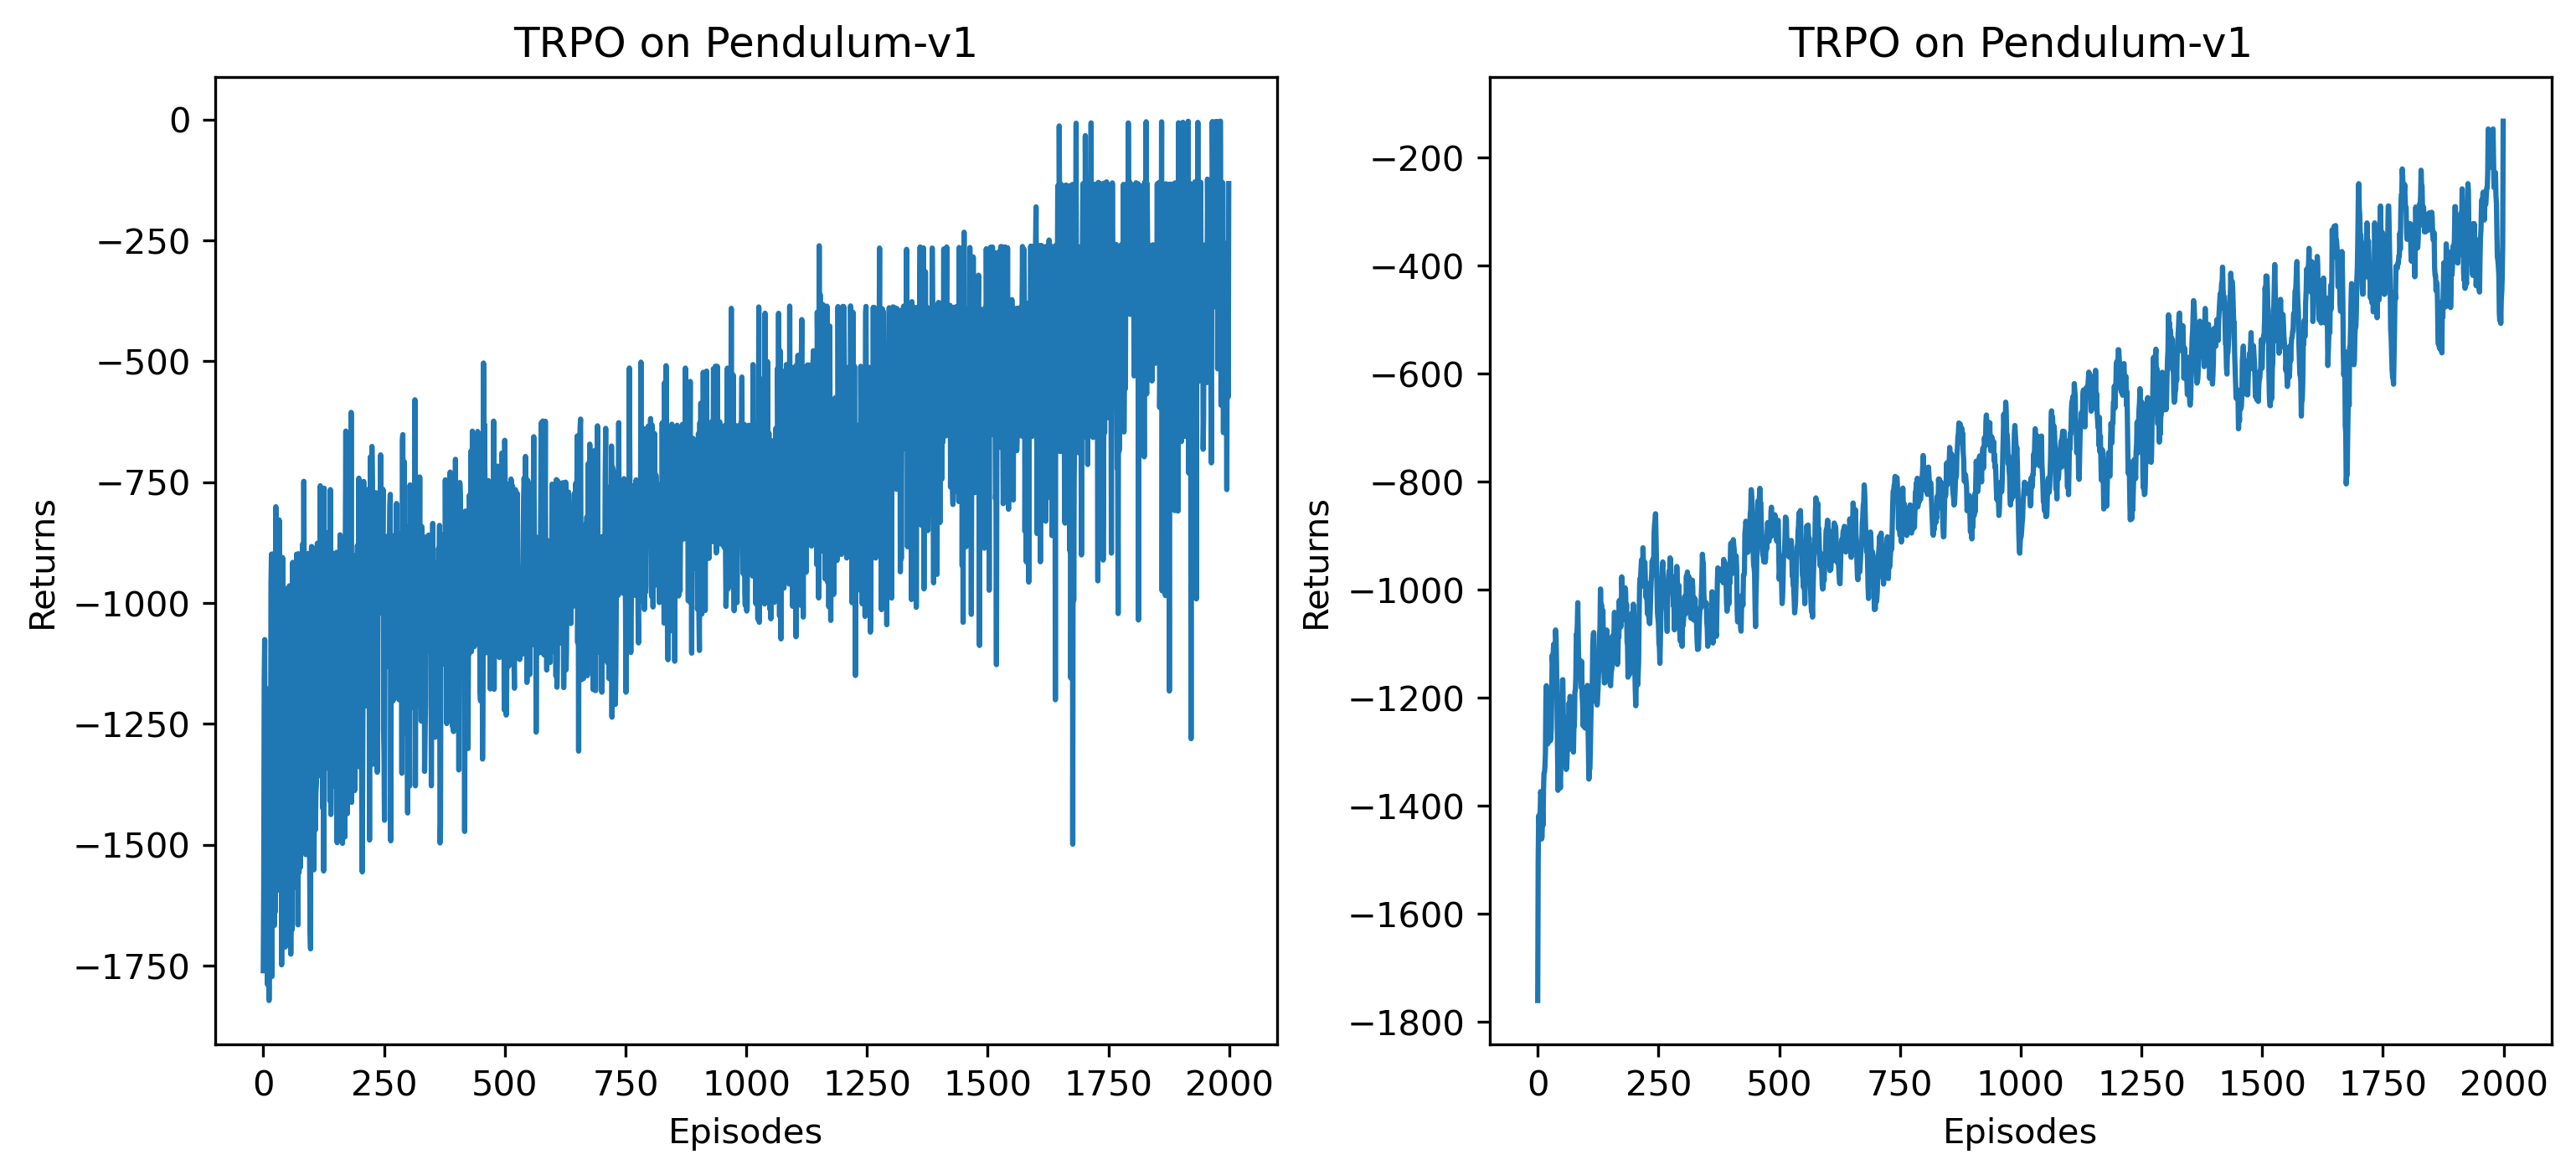

In [9]:
episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 9)
plt.figure(figsize = (12,5), dpi = 300)
plt.subplot(1,2,1)
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.subplot(1,2,2)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()

用 TRPO 在与连续动作交互的倒立摆环境中能够取得非常不错的效果，这说明 TRPO 中的信任区域优化方法在离散和连续动作空间都能有效工作。